```
Authors
```

```
Abhishek Kangale

Akashnil Roy

Ameya Kanawade

Moumita Ghosh

Praveen K Vadicharla

Vivek John P

Aravind Mano
```

# Importing Libraries

In [0]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style = 'white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
telecom_cust = pd.read_csv("/content/Telco-Customer-Churn.csv")

In [0]:
telecom_cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
telecom_cust["InternetService"].nunique()

3

#Data Pre-processing

In [0]:
# Checking the data types of all the columns
telecom_cust.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [0]:
#by observation, total charges is a numeric value but the data type as shown above is "object". 
#therefore to convert, parameter "errors=coerce" is passed and then datatype is of "float" type

telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')
telecom_cust.TotalCharges.dtype

dtype('float64')

In [0]:
#explore the data to see if there are any missing values.
telecom_cust.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [0]:
telecom_cust.Churn.value_counts(normalize=True)               #yes(1) is minority class...to improve recall and precision, increase observations of min.class in the dataset by SMOTE

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

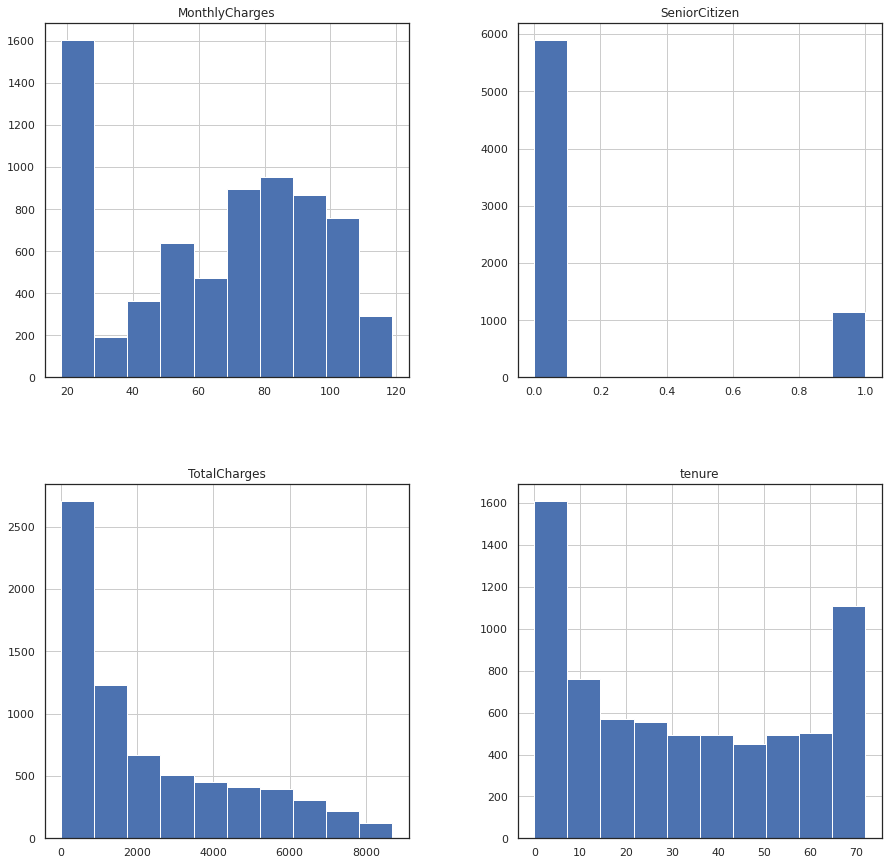

In [0]:
telecom_cust.hist(figsize=(15,15))
plt.show()

In [0]:
#After looking at the above output, we can say that there are 11 missing values for Total Charges. 
#total charges variable data in positively skewed ...using median imputation to handle missing values

In [0]:
telecom_cust.fillna(telecom_cust.median(), inplace=True)

In [0]:
telecom_cust.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [0]:
#Remove customer IDs from the data set
df2 = telecom_cust.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [0]:
#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


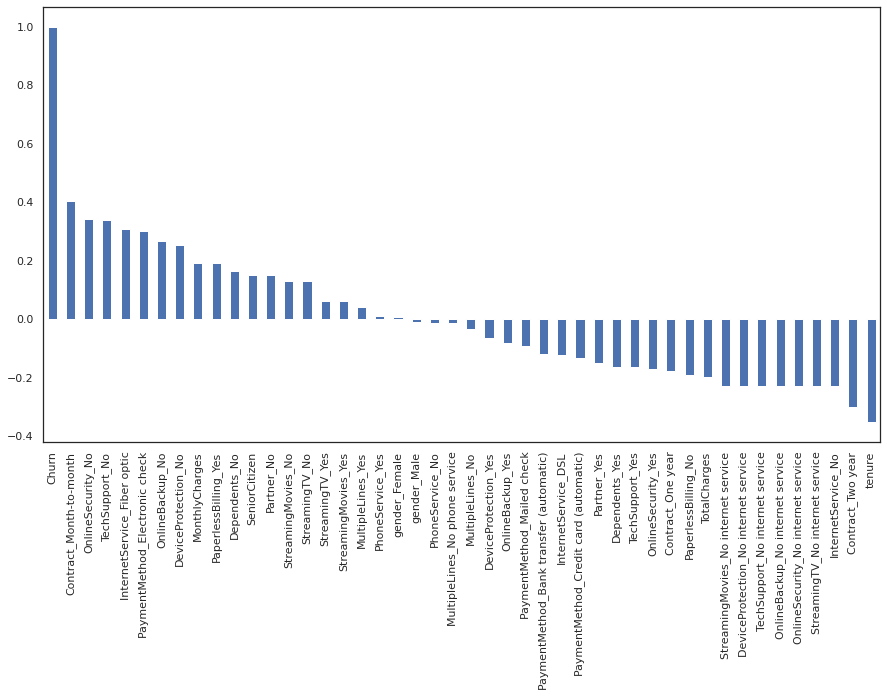

In [0]:
#Get Correlation of "Churn" with other variables:
#sns.heatmap(df_dummies.corr())
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. While, tenure, two year contracts seem to be negatively correlated with churn.

Interestingly, services such as Online security, streaming TV, online backup, tech support, etc. without internet connection seem to be negatively related to churn.

We will explore the patterns for the above correlations below before we delve into modelling and identifying the important variables.

#Data Exploration

A.) Demographics - Let us first understand the gender, age range, patner and dependent status of the customers

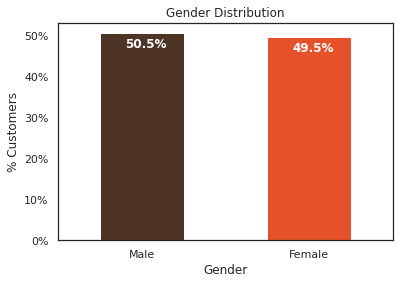

In [0]:
colors = ['#4D3425','#E4512B']
ax = (telecom_cust['gender'].value_counts()*100.0 /len(telecom_cust)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')


Gender Distribution - About half of the customers in our data set are male while the other half are female

Text(0.5, 1.0, '% of Senior Citizens')

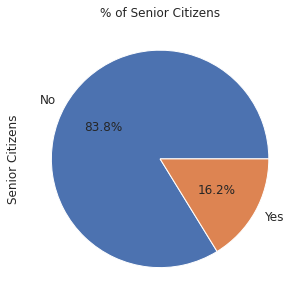

In [0]:
ax = (telecom_cust['SeniorCitizen'].value_counts()*100.0 /len(telecom_cust))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

Senior Citizens - There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.

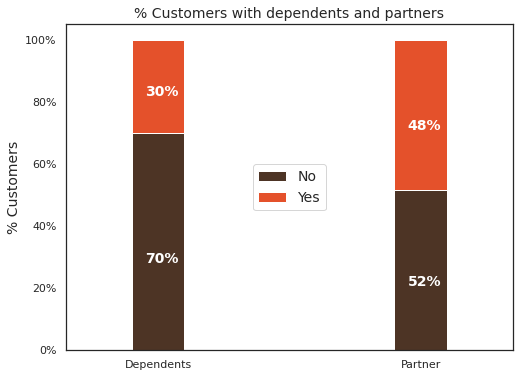

In [0]:
df2 = pd.melt(telecom_cust, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3*100/len(telecom_cust)
colors = ['#4D3425','#E4512B']
ax = df3.loc[:,'customerID'].plot.bar(stacked=True, color=colors,
                                      figsize=(8,6),rot = 0,
                                     width = 0.2)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('')
ax.set_title('% Customers with dependents and partners',size = 14)
ax.legend(loc = 'center',prop={'size':14})

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Partner and dependent status - About 50% of the customers have a partner, while only 30% of the total customers have dependents.

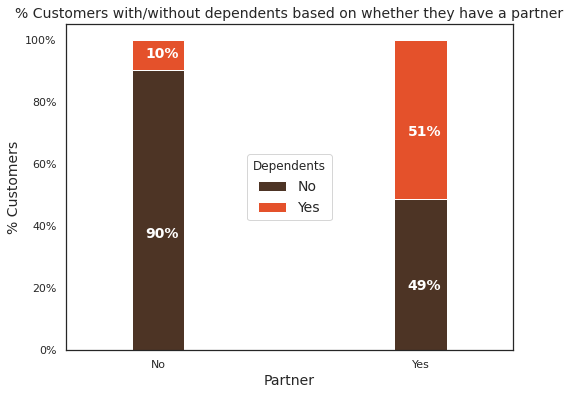

In [0]:
colors = ['#4D3425','#E4512B']
partner_dependents = telecom_cust.groupby(['Partner','Dependents']).size().unstack()

ax = (partner_dependents.T*100.0 / partner_dependents.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Dependents',fontsize =14)
ax.set_ylabel('% Customers',size = 14)
ax.set_title('% Customers with/without dependents based on whether they have a partner',size = 14)
ax.xaxis.label.set_size(14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Interestingly, among the customers who have a partner, only about half of them also have a dependent, while other half do not have any independents. Additionally, as expected, among the customers who do not have any partner, a majority (80%) of them do not have any dependents .

Text(0.5, 1.0, '# of Customers by their tenure')

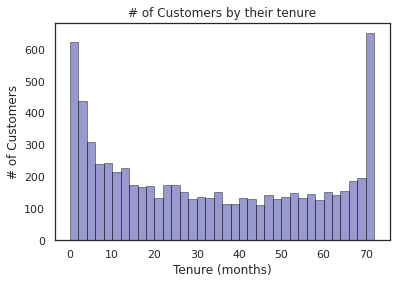

In [0]:
ax = sns.distplot(telecom_cust['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

Tenure: After looking at the below histogram we can see that a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. This could be potentially because different customers have different contracts. Thus based on the contract they are into it could be more/less easier for the customers to stay/leave the telecom company.

Text(0.5, 1.0, '# of Customers by Contract Type')

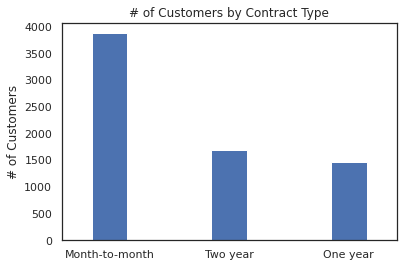

In [0]:
ax = telecom_cust['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

Contracts: To understand the above graph, lets first look at the # of customers by different contracts.

As we can see from this graph most of the customers are in the month to month contract. While there are equal number of customers in the 1 year and 2 year contracts.

Text(0.5, 1.0, 'Two Year Contract')

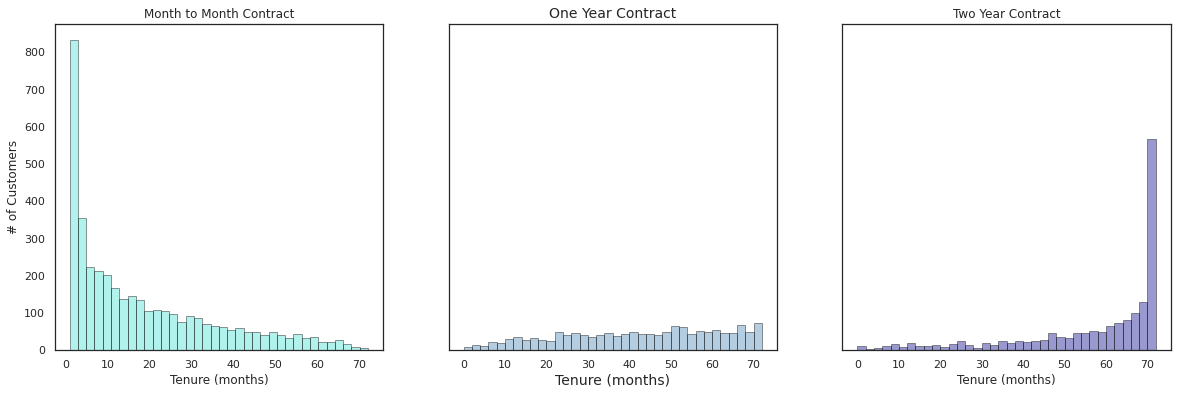

In [0]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='Month-to-month']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'turquoise',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Month to Month Contract')

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='One year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'steelblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Tenure (months)',size = 14)
ax.set_title('One Year Contract',size = 14)

ax = sns.distplot(telecom_cust[telecom_cust['Contract']=='Two year']['tenure'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'darkblue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract')

tenure of customers based on their contract type.

Interestingly most of the monthly contracts last for 1-2 months, while the 2 year contracts tend to last for about 70 months. This shows that the customers taking a longer contract are more loyal to the company and tend to stay with it for a longer period of time.

This is also what we saw in the earlier chart on correlation with the churn rate.

In [0]:
telecom_cust.columns.values

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

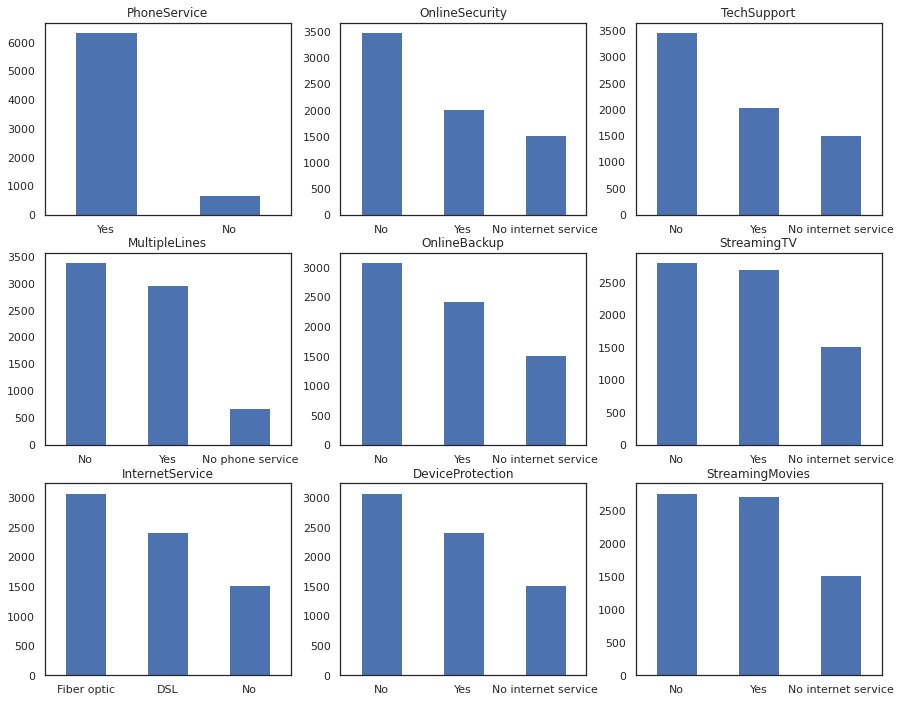

In [0]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services):
    if i < 3:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

the distribution of various services used by customers

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


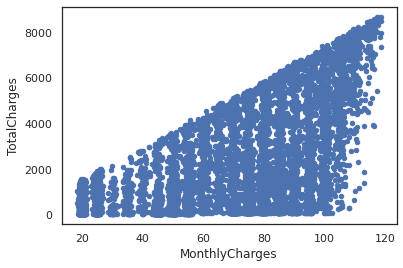

In [0]:
telecom_cust[['MonthlyCharges', 'TotalCharges']].plot.scatter(x = 'MonthlyCharges',
                                                              y='TotalCharges')

the total charges increases as the monthly bill for a customer increases.

#Lets first look at the churn rate in our data

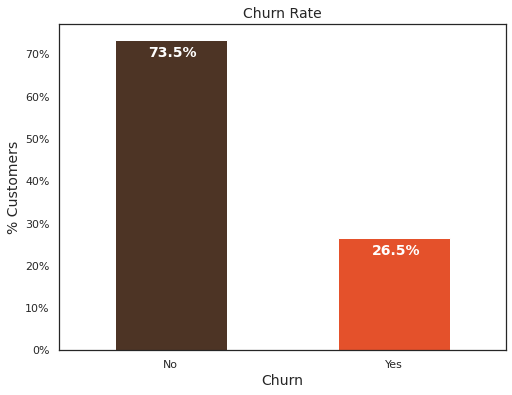

In [0]:
colors = ['#4D3425','#E4512B']
ax = (telecom_cust['Churn'].value_counts()*100.0 /len(telecom_cust)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold',
           size = 14)

In our data, 74% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

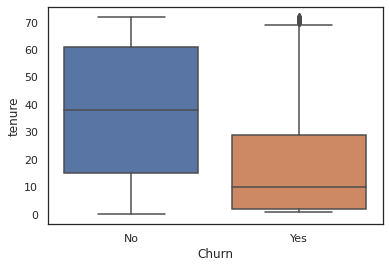

In [0]:
sns.boxplot(x = telecom_cust.Churn, y = telecom_cust.tenure)

the customers who do not churn, they tend to stay for a longer tenure with the telecom company.

In [0]:
telecom_cust.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

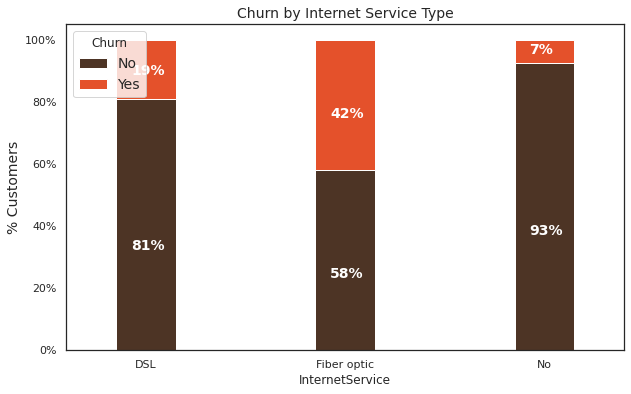

In [0]:
colors = ['#4D3425','#E4512B']
internetservice_churn = telecom_cust.groupby(['InternetService','Churn']).size().unstack()

ax = (internetservice_churn.T*100.0 / internetservice_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Internet Service Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Churn rate is highest for Internet service type for Fiber Optic and lowest for customers with no internet connection.

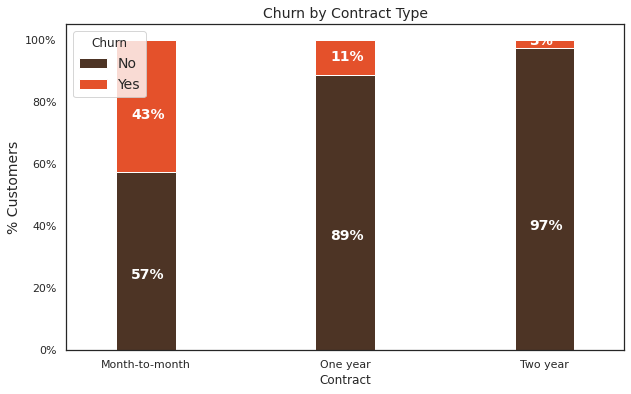

In [0]:
colors = ['#4D3425','#E4512B']
contract_churn = telecom_cust.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by Contract Type',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

Churn by Contract Type: Similar to what we saw in the correlation plot, the customers who have a month to month contract have a very high churn rate.

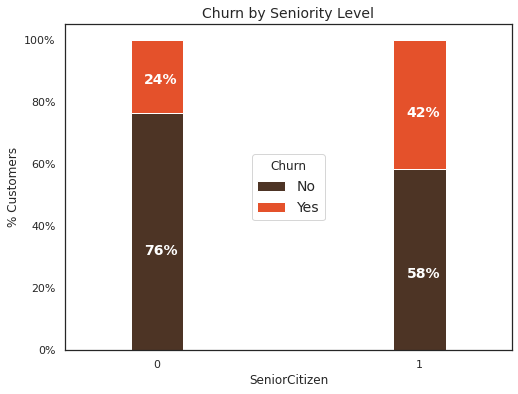

In [0]:
colors = ['#4D3425','#E4512B']
seniority_churn = telecom_cust.groupby(['SeniorCitizen','Churn']).size().unstack()

ax = (seniority_churn.T*100.0 / seniority_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.2,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (8,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='center',prop={'size':14},title = 'Churn')
ax.set_ylabel('% Customers')
ax.set_title('Churn by Seniority Level',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',size =14)

Churn by Seniority: Senior Citizens have almost double the churn rate than younger population.

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

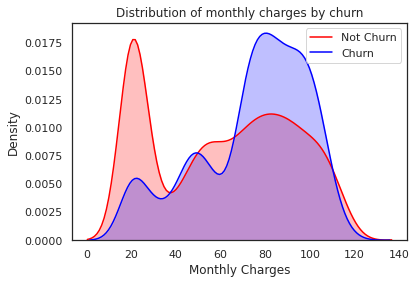

In [0]:
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

Churn by Monthly Charges: Higher % of customers churn when the monthly charges are high.

Text(0.5, 1.0, 'Distribution of total charges by churn')

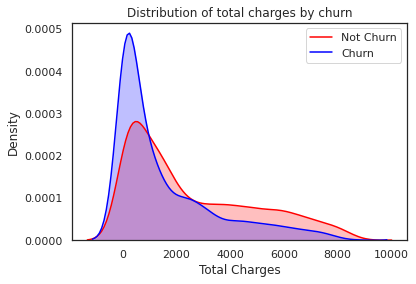

In [0]:
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

Churn by Total Charges: It seems that there is higher churn when the total charges are lower.

#Modeling

#1.  Logistic Regression

In [0]:
# We will use the data frame where we had created dummy variables
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

It is important to scale the variables in logistic regression so that all of them are within a range of 0 to 1.  # Non- Gaussian Distribution

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [0]:
X_train.shape

(4930, 45)

In [0]:
y_train.shape

(4930,)

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 1302
Before OverSampling, counts of label '0': 3628 



In [0]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))

0.8059630856601988


In [0]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,prediction_test))
pd.DataFrame(confusion_matrix(y_test,prediction_test), index = [['actual', 'actual'], ['non-churn', 'churn']], 
             columns = [['predicted', 'predicted'], ['non-churn', 'churn']])

[[1401  145]
 [ 265  302]]


predicted      
                 non-churn churn
actual non-churn      1401   145
       churn           265   302

In [0]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1546
           1       0.68      0.53      0.60       567

    accuracy                           0.81      2113
   macro avg       0.76      0.72      0.73      2113
weighted avg       0.80      0.81      0.80      2113



In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

In [0]:
# Get predicted probabilities
y_score1 = model.predict_proba(X_test)[:,1]

In [0]:
# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [0]:
print('roc_auc_score :', roc_auc_score(y_test, y_score1))

roc_auc_score : 0.8451605212062306


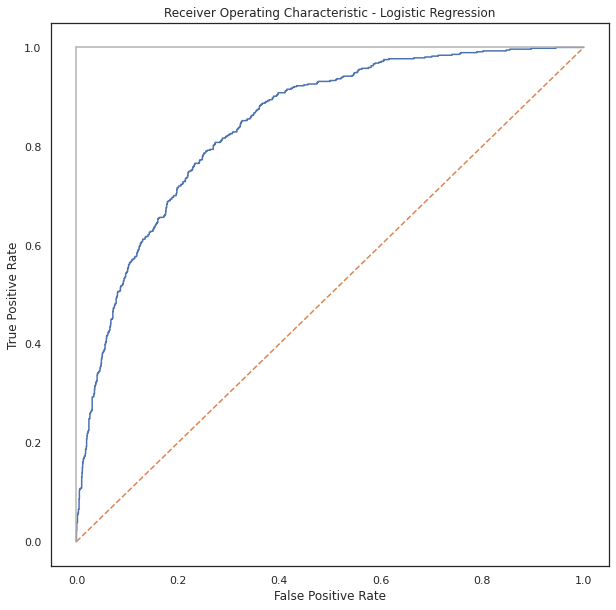

In [0]:
# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


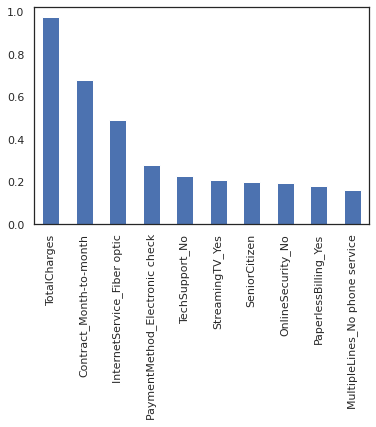

In [0]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0], index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


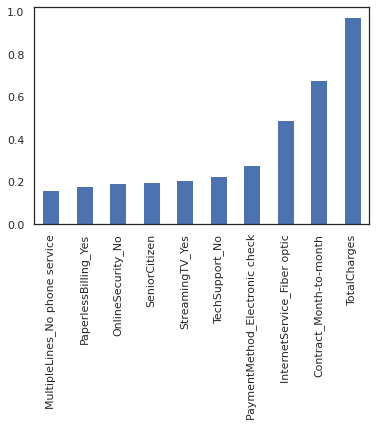

In [0]:
print(weights.sort_values(ascending = True)[-10:].plot(kind='bar'))

#Balancing Dataset

In [0]:
from imblearn.over_sampling import SMOTE

In [0]:
sm = SMOTE(random_state = 100) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
X_train_res.shape

(7256, 45)

In [0]:
y_train_res.shape

(7256,)

In [0]:
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, counts of label '1': 3628
After OverSampling, counts of label '0': 3628


In [0]:
req_var = X.columns 
X_train_res = pd.DataFrame(data = X_train_res, columns= req_var)
#y_train_res = pd.DataFrame(data = y_train_res, columns= output_var)

In [0]:
model = LogisticRegression()
result = model.fit(X_train_res, y_train_res)              #training using balanced data...
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))

0.763369616658779


In [0]:
pd.DataFrame(confusion_matrix(y_test,prediction_test), index = [['actual', 'actual'], ['non-churn', 'churn']], 
             columns = [['predicted', 'predicted'], ['non-churn', 'churn']])

predicted      
                 non-churn churn
actual non-churn      1166   380
       churn           120   447

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1546
           1       0.54      0.79      0.64       567

    accuracy                           0.76      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.76      0.77      2113

roc_auc_score : 0.8454902108416554


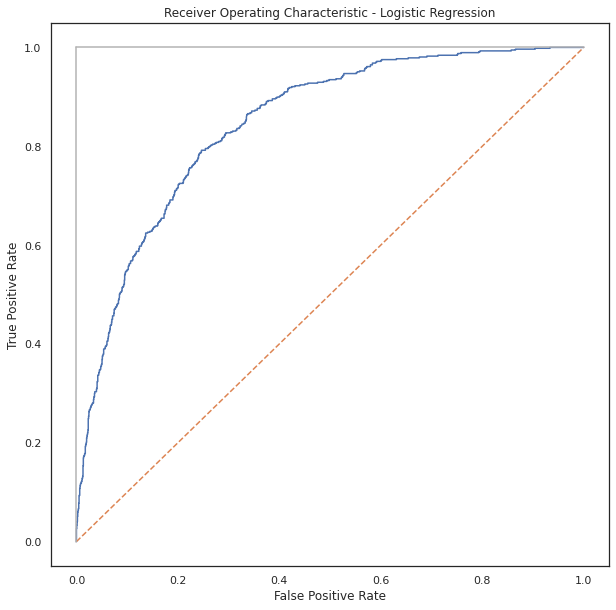

In [0]:
print(classification_report(y_test, prediction_test))
y_score1 = model.predict_proba(X_test)[:,1]
# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
print('roc_auc_score :', roc_auc_score(y_test, y_score1))
# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


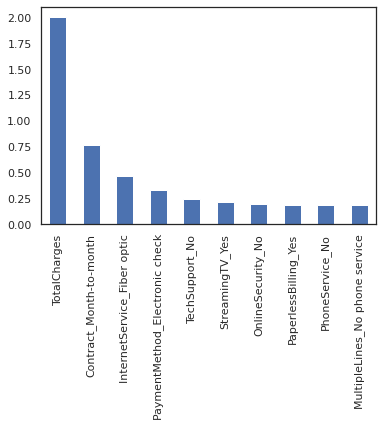

In [0]:
weights = pd.Series(model.coef_[0], index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))

#Observations

Observations

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:

As we saw in our EDA, having a 2 month contract reduces chances of churn. 2 month contract along with tenure have the most negative relation with Churn as predicted by logistic regressions
Having DSL internet service also reduces the proability of Churn
Lastly, total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are likely to churn because of it. I think we need to explore more to better understad why this is happening.
Any hypothesis on the above would be really helpful!

#2. Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)      # max features means bootstrapped samples for every DT  , n_est means no. of DTs
model_rf.fit(X_train_res, y_train_res)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.7775674396592522


In [0]:
pd.DataFrame(confusion_matrix(y_test,prediction_test), index = [['actual', 'actual'], ['non-churn', 'churn']], 
             columns = [['predicted', 'predicted'], ['non-churn', 'churn']])

predicted      
                 non-churn churn
actual non-churn      1232   314
       churn           156   411

In [0]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1546
           1       0.57      0.72      0.64       567

    accuracy                           0.78      2113
   macro avg       0.73      0.76      0.74      2113
weighted avg       0.80      0.78      0.79      2113



In [0]:
# Get predicted probabilities
y_score1 = model.predict_proba(X_test)[:,1]

In [0]:
# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [0]:
print('roc_auc_score :', roc_auc_score(y_test, y_score1))

roc_auc_score : 0.8454902108416554


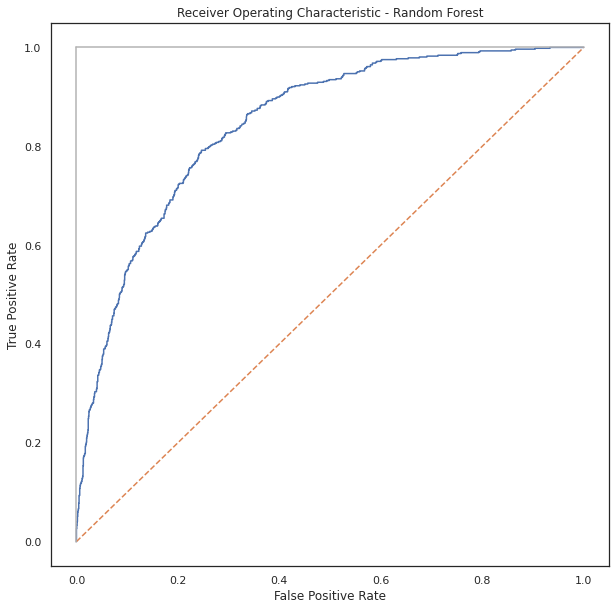

In [0]:
# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

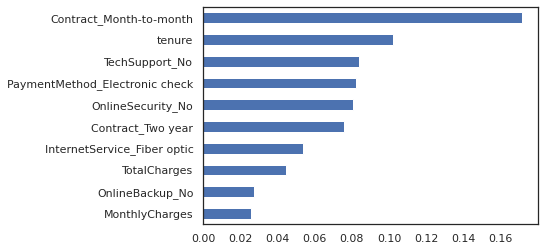

In [0]:
importances = model_rf.feature_importances_
weights = pd.Series(importances, index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

#Observations

From random forest algorithm, monthly contract, tenure and total charges are the most important predictor variables to predict churn.

The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

#3. Support Vector Machine (SVM)

In [0]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)   # comment out

In [0]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear') 
model.svm.fit(X_train_res, y_train_res)
preds = model.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.7439659252247989

In [0]:
pd.DataFrame(confusion_matrix(y_test,preds), index = [['actual', 'actual'], ['non-churn', 'churn']], 
             columns = [['predicted', 'predicted'], ['non-churn', 'churn']])

predicted      
                 non-churn churn
actual non-churn      1113   433
       churn           108   459

In [0]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1546
           1       0.51      0.81      0.63       567

    accuracy                           0.74      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.81      0.74      0.76      2113



In [0]:
# Get predicted probabilities
y_score1 = model.predict_proba(X_test)[:,1]

In [0]:
# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [0]:
print('roc_auc_score :', roc_auc_score(y_test, y_score1))

roc_auc_score : 0.8454902108416554


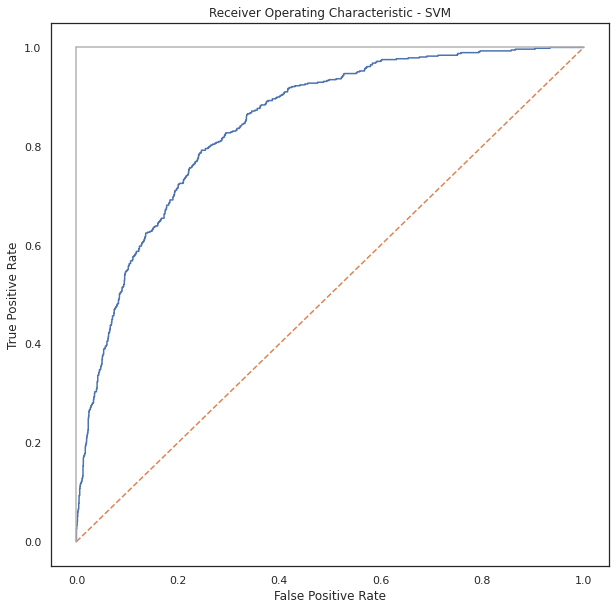

In [0]:
# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
#importances = model.svm.feature_importances_
#importances = f_importances(model.svm.coef_[0], X)
#weights = pd.Series(importances, index=X.columns.values)
#weights.sort_values()[-10:].plot(kind = 'barh')

# Observations

SVM  was able to increase the accuracy to upto 82%. However, we need to take a deeper look at the true positive and true negative rates, including the Area Under the Curve (AUC) for a better prediction.

#4. XGBoost

In [0]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_res, y_train_res)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.7893989588263133

In [0]:
# Create the Confusion matrix
pd.DataFrame(confusion_matrix(y_test,preds), index = [['actual', 'actual'], ['non-churn', 'churn']], 
             columns = [['predicted', 'predicted'], ['non-churn', 'churn']])

predicted      
                 non-churn churn
actual non-churn      1287   259
       churn           186   381

In [0]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1546
           1       0.60      0.67      0.63       567

    accuracy                           0.79      2113
   macro avg       0.73      0.75      0.74      2113
weighted avg       0.80      0.79      0.79      2113



In [0]:
# Get predicted probabilities
y_score1 = model.predict_proba(X_test)[:,1]

In [0]:
# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

In [0]:
print('roc_auc_score :', roc_auc_score(y_test, y_score1))

roc_auc_score : 0.8469082185123582


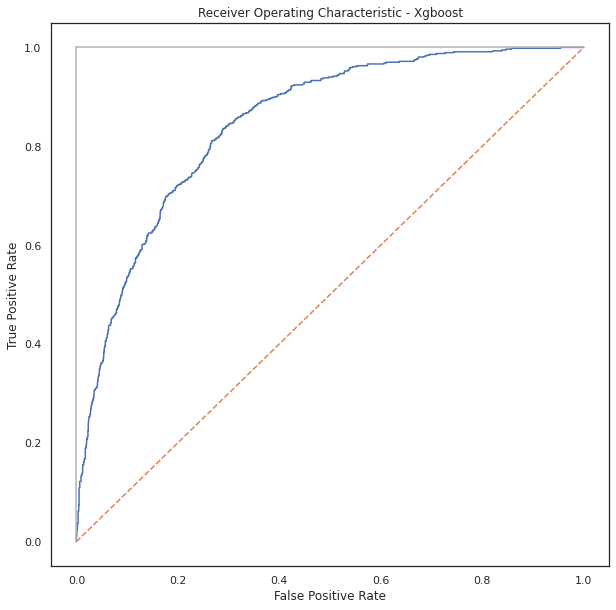

In [0]:
# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Xgboost')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#observation

Interestingly with XG Boost I was able to increase the accuracy on test data to almost 83%. Clearly, XG Boost is a winner among all other techniques. XG Boost is a slow learning model and is based on the concept of Boosting

In [0]:
telecom_cust.info

<bound method DataFrame.info of       customerID  gender  SeniorCitizen  ... MonthlyCharges TotalCharges  Churn
0     7590-VHVEG  Female              0  ...          29.85        29.85     No
1     5575-GNVDE    Male              0  ...          56.95      1889.50     No
2     3668-QPYBK    Male              0  ...          53.85       108.15    Yes
3     7795-CFOCW    Male              0  ...          42.30      1840.75     No
4     9237-HQITU  Female              0  ...          70.70       151.65    Yes
...          ...     ...            ...  ...            ...          ...    ...
7038  6840-RESVB    Male              0  ...          84.80      1990.50     No
7039  2234-XADUH  Female              0  ...         103.20      7362.90     No
7040  4801-JZAZL  Female              0  ...          29.60       346.45     No
7041  8361-LTMKD    Male              1  ...          74.40       306.60    Yes
7042  3186-AJIEK    Male              0  ...         105.65      6844.50     No

[7043 r